# 実習10-1 画像分類3（予測精度の向上）

前回の実習で、CNNを使用た猫と犬の画像分類プログラムを作成した。今回は、その予測精度の向上を目指す。

**実習09-2が前提のため、そちらを先に実施すること。**

**学習に時間がかかるので、可能であればランタイムのタイプをGPUにする。**
(ランタイム＞ランタイムのタイプを変更)


import文は最初にまとめておいてもいいです。

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# import 文をまとめる場合はここに
import tensorflow as tf
from tensorflow import keras

## 1. データセットの準備


### 1-1. zipファイルのダウンロードと展開
犬と猫の画像データセットをダウンロードして展開する。前回のプログラムをコピーして実施する。

In [ ]:
# ダウンロード元URL
_URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'

# get_fileを使用してzipをダウンロードし展開（import tensorflow as tf必要）
# ダウンロード先（cache_subdir）は必要に応じて変更する
path_to_zip = keras.utils.get_file('cats_and_dogs.zip', origin=_URL, extract=True, cache_subdir='/content/datasets')

68606236/68606236 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


### 1-2. データの前処理
ImageDataGeneratorのセットアップ部分をコピーして実施する。（とりあえず前回のまま）

In [ ]:
# ジェネレータのセットアップ（訓練用、テスト用それぞれ）
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# 検証データのジェネレータは自分で作成
val_img_gen = ImageDataGenerator(rescale=1./255)
# 学習データのジェネレータ
train_img_gen = ImageDataGenerator(rescale=1./255)


```
train_data_gen = train_img_gen.flow_from_directory(directory='学習用データのあるディレクトリ',
                                                           shuffle=True, #シャッフルするか
                                                           target_size=(IMG_HEIGHT, IMG_WIDTH), #出力画像ファイル
                                                           class_mode='binary', # ラベル（出力）の種類
                                                           seed=学籍番号)
```


In [ ]:
# 縦横のサイズを変数に入れておく（実行すること）
IMG_HEIGHT = 224
IMG_WIDTH = 224

In [ ]:
# 訓練用
train_data_gen = train_img_gen.flow_from_directory(directory='/content/datasets/cats_and_dogs_filtered/train',
                                                           shuffle=True, #シャッフルするか
                                                           target_size=(IMG_HEIGHT, IMG_WIDTH), #出力画像ファイル
                                                           class_mode='binary', # ラベル（出力）の種類
                                                           seed=2220042)

Found 2000 images belonging to 2 classes.


In [ ]:
# 検証用
val_data_gen = val_img_gen.flow_from_directory(directory='/content/datasets/cats_and_dogs_filtered/validation',
                                                           shuffle=True, #シャッフルするか
                                                           target_size=(IMG_HEIGHT, IMG_WIDTH), #出力画像ファイル
                                                           class_mode='binary', # ラベル（出力）の種類
                                                           seed=2220042)

Found 1000 images belonging to 2 classes.


## 2. モデルの作成と精度の確認

### 2-1. モデルの構成と確認
前回と同じモデルを作成する。（パラメータの変更がしやすいように関数化し、.add()を使用して作成してもよい）

```
# とりあえず前回と同じモデル
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense

model = tf.keras.Sequential([
    Input(shape=(IMG_HEIGHT,IMG_WIDTH,3)),
    Conv2D(32, 3, padding='same', activation='relu'),
    MaxPooling2D(4),
    Flatten(),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])
```

In [ ]:
# とりあえず前回と同じモデル
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense

model = tf.keras.Sequential([
    Input(shape=(IMG_HEIGHT,IMG_WIDTH,3)),
    Conv2D(32, 3, padding='same', activation='relu'),
    MaxPooling2D(4),
    Flatten(),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])

コンパイルする

In [ ]:
# モデルのコンパイル
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

summary()で確認する。

In [ ]:
# 作成と確認
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 224, 224, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 56, 56, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 100352)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 32)                  │       3,211,296 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,212,225 (12.25 MB)

 Trainable params: 3,212,225 (12.25 MB)

 Non-trainable params: 0 (0.00 B)

### 2-2 モデルの訓練、精度の確認
fitで現時点での訓練誤差とテスト誤差（精度）確認する。後でフラフ化できるように、戻り値を変数に入れておく。できれば70%以上の精度ができるように繰り返し実行するかエポック数を増やす。



In [ ]:
# 訓練と精度の確認
hist = model.fit(train_data_gen, validation_data=val_data_gen, epochs=20)

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


63/63 ━━━━━━━━━━━━━━━━━━━━ 15s 158ms/step - accuracy: 0.5201 - loss: 1.4749 - val_accuracy: 0.6000 - val_loss: 0.6471
Epoch 2/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 91ms/step - accuracy: 0.6180 - loss: 0.6459 - val_accuracy: 0.6460 - val_loss: 0.6244
Epoch 3/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 8s 113ms/step - accuracy: 0.7110 - loss: 0.5903 - val_accuracy: 0.6420 - val_loss: 0.6148
Epoch 4/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 10s 103ms/step - accuracy: 0.7443 - loss: 0.5338 - val_accuracy: 0.6700 - val_loss: 0.5784
Epoch 5/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 8s 121ms/step - accuracy: 0.8032 - loss: 0.4600 - val_accuracy: 0.7110 - val_loss: 0.5532
Epoch 6/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 100ms/step - accuracy: 0.8526 - loss: 0.3853 - val_accuracy: 0.7030 - val_loss: 0.5685
Epoch 7/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 105ms/step - accuracy: 0.8968 - loss: 0.3141 - val_accuracy: 0.6880 - val_loss: 0.5871
Epoch 8/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 10s 110ms/step - accuracy: 0.9200 - loss: 0.2782 - val_accuracy: 0.6770 - va

学習の過程と結果をグラフ化する。

In [ ]:
# このまま実行する
import matplotlib.pyplot as plt

# 後のために、グラフを表示する関数を作成しておく
def plot_graphs(hist, metric):

  # ----------------------------
  # 各epochでの誤差と精度を取得
  # ----------------------------
  met      = hist.history[     metric ]
  val_met  = hist.history[ 'val_'+metric ]
  loss     = hist.history[    'loss' ]
  val_loss = hist.history['val_loss' ]

  epochs   = range(len(met)) # Get number of epochs

  # ---------------------------------------------
  # エポック数に対する誤差を表示（片対数グラフ）
  # --------------------------------------------
  plt.plot  ( epochs,     loss, label='loss')
  plt.plot  ( epochs, val_loss, label='val_loss')
  plt.title ('Training and validation loss'   )
  plt.legend()
  plt.yscale('log')
  plt.figure()
  plt.show()

  # ------------------------------------------------
  # エポック数に対するメトリックの値を表示
  # ------------------------------------------------
  plt.plot  ( epochs,     met, label='met' )
  plt.plot  ( epochs, val_met, label='val_met')
  plt.title ('Training and validation metric value')
  plt.legend()
  plt.figure()
  plt.show()

損失関数の値（loss）と正解率（accuracy）をグラフ化して学習結果を視覚的に確認する。
```
# lossはデフォルトで表示するので、accuracyを指定
plot_graphs(hist, 'accuracy')
```

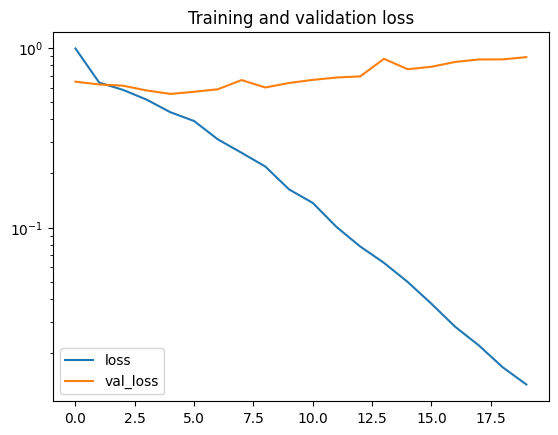

<Figure size 640x480 with 0 Axes>

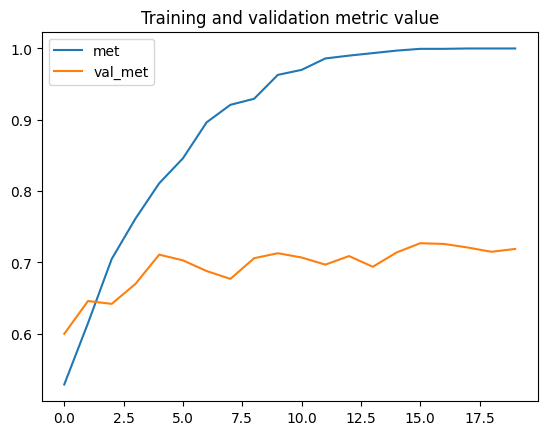

<Figure size 640x480 with 0 Axes>

In [ ]:
# グラフの描画
plot_graphs(hist, 'accuracy')

## 3. モデルの調整と画像データの拡張
精度の向上や過学習を避けるため、モデルの調整と画像データの拡張を行ってみる。

### 3-1. モデルの検討
*   層やフィルタを検討する。層を少し増やしたり、フィルタのサイズや数を変更したりしてみる。
*   各層または一部の層の間にBatchNormalization()やDropout(確率)を挿入し、過学習を避けられるかを確認してみる。



```
## ここにモデル作成関数を再び書いてもいいし、上に書いたものを変更してもよい。
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras import regularizers

def build_model2(drop=0.2):
  model = tf.keras.Sequential()
  model.add(Input(shape=(IMG_HEIGHT, IMG_WIDTH,3)))
  model.add(Conv2D(16, 3, padding='same', activation='relu'))
  model.add(MaxPooling2D(4))
  model.add(Conv2D(16, 3, padding='same', activation='relu'))
  model.add(MaxPooling2D(4))
  model.add(Conv2D(16, 3, padding='same', activation='relu'))
  model.add(MaxPooling2D(2,2))
  model.add(Flatten())
  model.add(Dropout(drop))
  model.add(Dense(64, activation='relu', kernel_regularizer='l2'))
  model.add(Dense(1, activation='sigmoid'))
  #コンパイルも関数内に含める
  model.compile(loss='binary_crossentropy', optimizer='adam',metrics=['accuracy'])
  return model

```

In [ ]:
## ここにモデル作成関数を再び書いてもいいし、上に書いたものを変更してもよい。
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras import regularizers

# def build_model2(drop=0.2):
def build_model2():
  model = tf.keras.Sequential()
  model.add(Input(shape=(IMG_HEIGHT, IMG_WIDTH,3)))
  model.add(Conv2D(16, 3, padding='same', activation='relu'))
  model.add(MaxPooling2D(4))
  model.add(Conv2D(16, 3, padding='same', activation='relu'))
  model.add(MaxPooling2D(4))
  model.add(Conv2D(16, 3, padding='same', activation='relu'))
  model.add(MaxPooling2D(2,2))
  model.add(Flatten())
  # model.add(Dropout(drop))
  # model.add(Dense(64, activation='relu', kernel_regularizer='l2'))
  model.add(Dense(64, activation='relu'))
  model.add(Dense(1, activation='sigmoid'))
  #コンパイルも関数内に含める
  model.compile(loss='binary_crossentropy', optimizer='adam',metrics=['accuracy'])
  return model

### 3-2. 入力データの水増し
画像分類では、入力画像を水増しするための前処理を行うことが一般的である。
同じ入力画像でも、少し位置がズレるだけで入力データは全く異なるため、これらの処理を行って入力画像の種類を増やし、精度の向上を目指す。

データの水増しは訓練データのみ行えばよい。ImageDataGeneratorを作成する際に、画像水増しのために使用する手法の種類とパラメータを指定できる。

詳しくは以下を参照。
[https://keras.io/ja/preprocessing/image/](https://keras.io/ja/preprocessing/image/)

```
# 訓練データのみ変更する
train_img_gen = ImageDataGenerator(rescale=1./255, rotation_range=45.0,width_shift_range=0.1) # 水増し用パラメータを追加
train_data_it = train_img_gen.flow_from_directory(directory='/content/datasets/cats_and_dogs_filtered/train/',
                                                           shuffle=True,
                                                           target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                           class_mode='binary',
                                                           seed=学籍番号)
```

In [ ]:
# 訓練データのみ変更する
# ImageDataGeneratorとflow_from_directory
train_img_gen = ImageDataGenerator(rescale=1./255, rotation_range=45.0,width_shift_range=0.1) # 水増し用パラメータを追加
train_data_it = train_img_gen.flow_from_directory(directory='/content/datasets/cats_and_dogs_filtered/train/',
                                                           shuffle=True,
                                                           target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                           class_mode='binary',
                                                           seed=2220042)

Found 2000 images belonging to 2 classes.


### 3-3 精度向上

モデルの構成やハイパーパラメータ（フィルタ数、dropout率、層の数などなど）、ImageDataGeneratorのパラメータを変更し、evaluateの精度向上を目指してみましょう。

**1つモデルの学習に、それなりに時間がかかります。試してみるモデルやパラメータの種類はできる範囲で大丈夫です。**

In [ ]:
# モデル作成と確認
model = build_model2()
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)                    │ (None, 224, 224, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 56, 56, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 56, 56, 16)          │           2,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 14, 14, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 14, 14, 16)          │           2,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 7, 7, 16)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 784)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 784)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 64)                  │          50,240 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 55,393 (216.38 KB)

 Trainable params: 55,393 (216.38 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# 学習と評価
hist = model.fit(train_data_it, validation_data=val_data_gen, epochs=20)

Epoch 1/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 35s 467ms/step - accuracy: 0.5035 - loss: 1.4760 - val_accuracy: 0.6040 - val_loss: 0.8398
Epoch 2/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 35s 407ms/step - accuracy: 0.5024 - loss: 0.7950 - val_accuracy: 0.5500 - val_loss: 0.7188
Epoch 3/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 41s 405ms/step - accuracy: 0.5402 - loss: 0.7140 - val_accuracy: 0.5410 - val_loss: 0.6896
Epoch 4/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 41s 405ms/step - accuracy: 0.5633 - loss: 0.6899 - val_accuracy: 0.5620 - val_loss: 0.6760
Epoch 5/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 27s 393ms/step - accuracy: 0.5911 - loss: 0.6814 - val_accuracy: 0.6050 - val_loss: 0.6742
Epoch 6/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 42s 406ms/step - accuracy: 0.5805 - loss: 0.6811 - val_accuracy: 0.6850 - val_loss: 0.6236
Epoch 7/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 28s 403ms/step - accuracy: 0.6802 - loss: 0.6363 - val_accuracy: 0.7070 - val_loss: 0.5970
Epoch 8/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 42s 428ms/step - accuracy: 0.6730 - loss: 0.6162 - val_accu

損失関数の値（loss）と正解率（accuracy）をグラフ化して学習結果を視覚的に確認する。

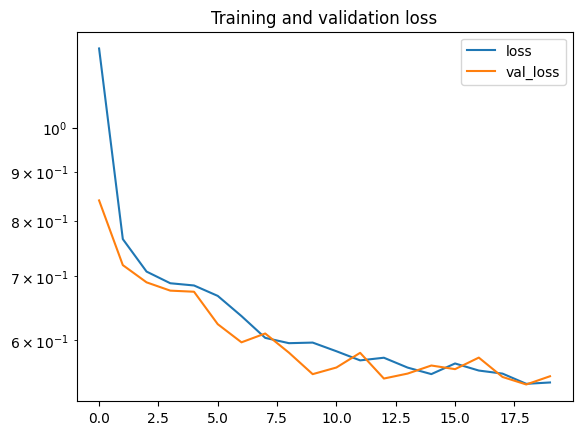

<Figure size 640x480 with 0 Axes>

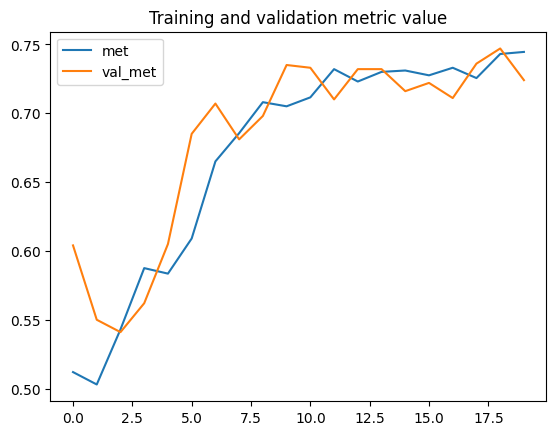

<Figure size 640x480 with 0 Axes>

In [ ]:
# グラフの描画
plot_graphs(hist, 'accuracy')

実施した範囲で構いませんので、今回モデルの調整と訓練データの水増しで行ってみたことを以下に記述してください。

*   モデル調整で実施したこと**[　学習の層を増えます　]**
*   訓練データの水増しで実施したこと**[　角度の設定　]**

